# Starting with a Simple Example: Digits Data from sklearn
Let's start our adventure into convolutional networks with a simple example of the digits dataset. This was not always such a simple example, but modern day computing power and open source tools has made it a significantly more tractable problem. 

Note that we will not be using the `tf.data` format for these example since they are sufficiently small enough to work with. 

Moreover, we will employ the sequential API in keras, which assumes that the output from the previous operation becomes the input to the next operation. Thus, we can build feedforward networks by simply adding operations in a list. Specifically, we will use the `model.add( )` function.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

print('Tensorflow version:',tf.__version__)

tf.random.set_seed(2)
np.random.seed(0) # using this to help make results more reproducible
tf.config.list_physical_devices('GPU')

digits = datasets.load_digits()

# NORMALIZATION, VERY IMPORTANT, Like we showed in Neural Network Lab
X = digits.data.astype(np.float32)/16.0 - 0.5
y = digits.target.astype(np.int32)

X = X.reshape((X.shape[0],8,8,1)) # reshape as images

# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Split X_train again to create validation data
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

X_train.shape

Tensorflow version: 2.16.2


(1437, 8, 8, 1)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

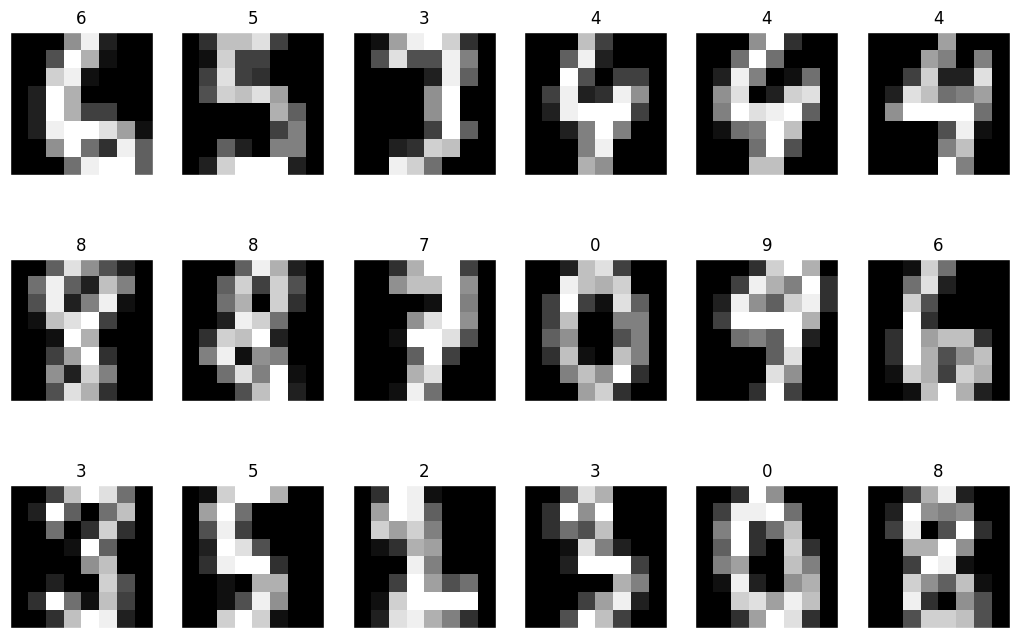

In [3]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze(), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, 8, 8) # defaults to showing a 3 by 6 subset of the images



____
# A very Simple ConvNet Versus a Raw Pixel Input MLP
Wouldn't it be great if we did not need to specify the correct filters (like in DAISY)? What if we could just let the weights of the convolution be found through neural network training methods. Of course, we can! Let's do one example with a simple CNN architecture and compare it to the performance of a pixel wise MLP.

In general, the flattened images placed through a MLP can be quite accurate (as we have seen in the past). Even so, using convolitional filters and pooling should provide us with some better resilience to small perturbations in the images. 

**BONUS**: Let's start using the sequential API, rather than the funcitonal API. Also, we can use numpy matrices instead of the tf.data format for smaller examples. The format will mean that the models are not quite as fast for loading data, but since everythign fits in memory its not a huge concern. 

Note that, since we are not using tf.data, we need to normalize the input data directly, rather than as part of th model. 

In [4]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model

keras.__version__

'3.5.0'

In [5]:
NUM_CLASSES = 10
print(X_train.shape)
print(X_test.shape)

(1437, 8, 8, 1)
(360, 8, 8, 1)


In [6]:
%%time

# CREATE A BASELINE MLP WITH THREE LAYERS

# since this is not binary, we should go ahead and one-hot encode the inputs
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=1, units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

/Users/eclarson/miniconda3/envs/mlenv3_11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-18 08:05:36.651586: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-18 08:05:36.651653: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-11-18 08:05:36.651793: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-11-18 08:05:36.652054: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-18 08:05:36.652500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.c

CPU times: user 23.1 s, sys: 14.5 s, total: 37.6 s
Wall time: 30.3 s


In [7]:
%%time

# CREATE A CNN WITH ONLY ONE CONVOLUTIONAL LAYER AND ONE OUTPUT LAYER

# make a CNN with conv layer and max pooling
cnn = Sequential() 
cnn.add( Conv2D(filters=16, kernel_size= (2, 2), padding='same', 
                input_shape=(8,8,1),
               ) )

cnn.add( MaxPooling2D(pool_size=(2, 2)) )
cnn.add( Activation('relu') )
# add one layer on flattened output
cnn.add( Flatten() )
cnn.add( Dense(NUM_CLASSES) )
cnn.add( Activation('softmax') )

print(cnn.summary())

plot_model(
    cnn, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

/Users/eclarson/miniconda3/envs/mlenv3_11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 16)       │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,650 (10.35 KB)

 Trainable params: 2,650 (10.35 KB)

 Non-trainable params: 0 (0.00 B)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.
CPU times: user 45.2 ms, sys: 22.7 ms, total: 67.8 ms
Wall time: 343 ms


In [8]:
%%time 

# the shape of input (batch x h x w x channels)
print(X_train.shape)

# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

(1437, 8, 8, 1)
CPU times: user 21.1 s, sys: 14.3 s, total: 35.4 s
Wall time: 27 s


In [9]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(f'CNN: {acc_cnn:.4f}')
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(f'MLP: {acc_mlp:.4f}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


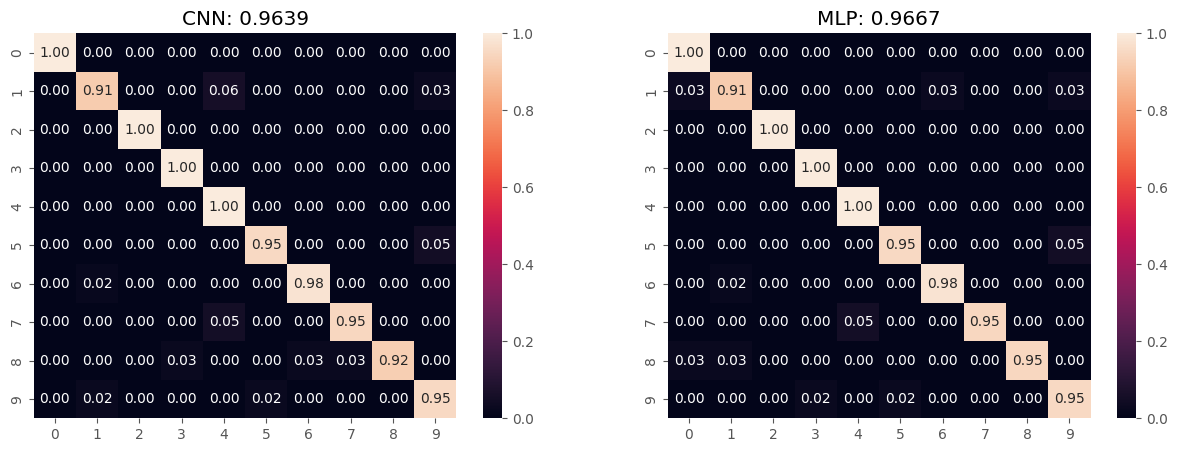

In [10]:
compare_mlp_cnn(cnn,mlp,X_test,y_test)

/Users/eclarson/miniconda3/envs/mlenv3_11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "3by3_kernel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 16)       │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,730 (10.66 KB)

 Trainable params: 2,730 (10.66 KB)

 Non-trainable params: 0 (0.00 B)

None
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
CPU times: user 21.8 s, sys: 14.5 s, total: 36.3 s
Wall time: 27.1 s


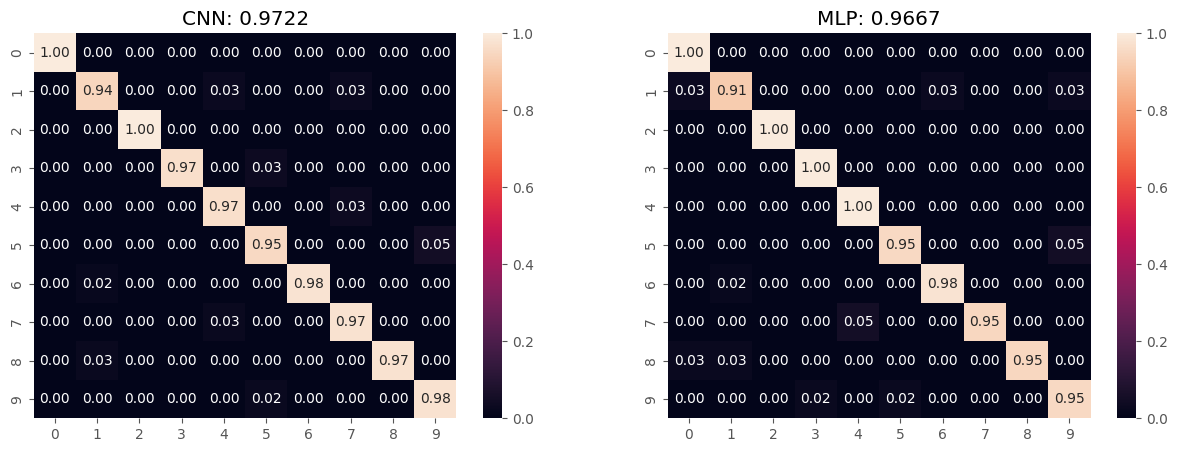

In [11]:
%%time

# changes: 
#    1. increased kernel size
cnn2 = Sequential(name='3by3_kernel')
cnn2.add( Conv2D(filters=16, kernel_size= (3, 3), 
                padding='same', input_shape=(8,8,1),
                ) )
cnn2.add( Activation('relu') )
cnn2.add( MaxPooling2D(pool_size=(2, 2)) )
# add one layer on flattened output
cnn2.add( Flatten() )
cnn2.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

input_shape = [None, 8,8,1]
cnn2.build(input_shape)
print(cnn2.summary())

cnn2.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn2,mlp,X_test,y_test)

Model: "two_layer_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,858 (42.41 KB)

 Trainable params: 10,858 (42.41 KB)

 Non-trainable params: 0 (0.00 B)

None
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
CPU times: user 25.1 s, sys: 15.5 s, total: 40.5 s
Wall time: 32.3 s


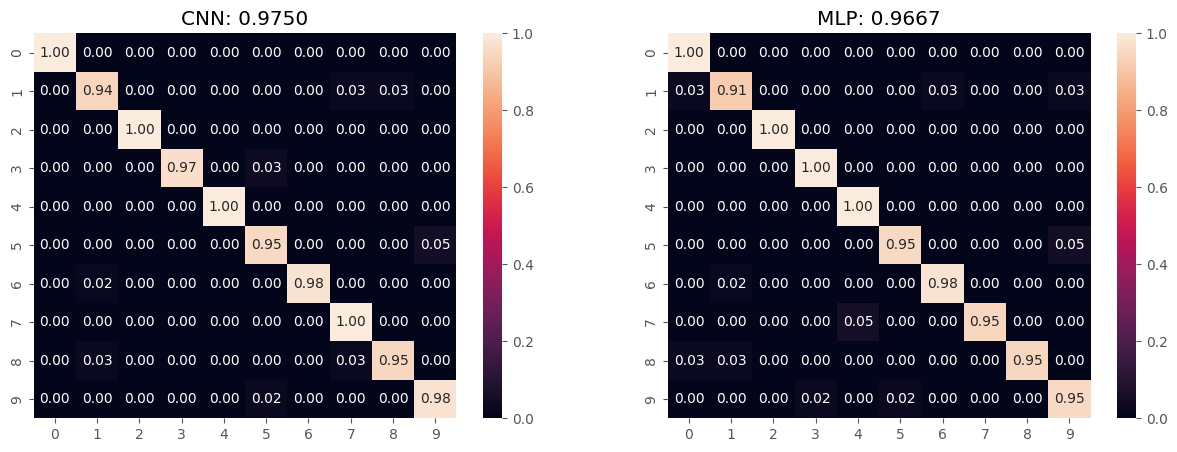

In [12]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer 
cnn3 = Sequential(name='two_layer_cnn')

num_filt_layers = [32, 32]
for num_filters in num_filt_layers:
    cnn3.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same',
                     ) )
    cnn3.add( Activation('relu'))
    cnn3.add( MaxPooling2D(pool_size=(2, 2)) )
    

# add one layer on flattened output
cnn3.add( Flatten() )
cnn3.add( Dense(NUM_CLASSES) )
cnn3.add( Activation('softmax') )

# Let's train the model 
cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

input_shape = [None, 8,8,1]
cnn3.build(input_shape)
print(cnn3.summary())

cnn3.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn3,mlp,X_test,y_test)

Model: "two_layer_few_filters"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 16)       │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,710 (73.09 KB)

 Trainable params: 18,710 (73.09 KB)

 Non-trainable params: 0 (0.00 B)

None
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
CPU times: user 28.2 s, sys: 15.7 s, total: 43.9 s
Wall time: 33.8 s


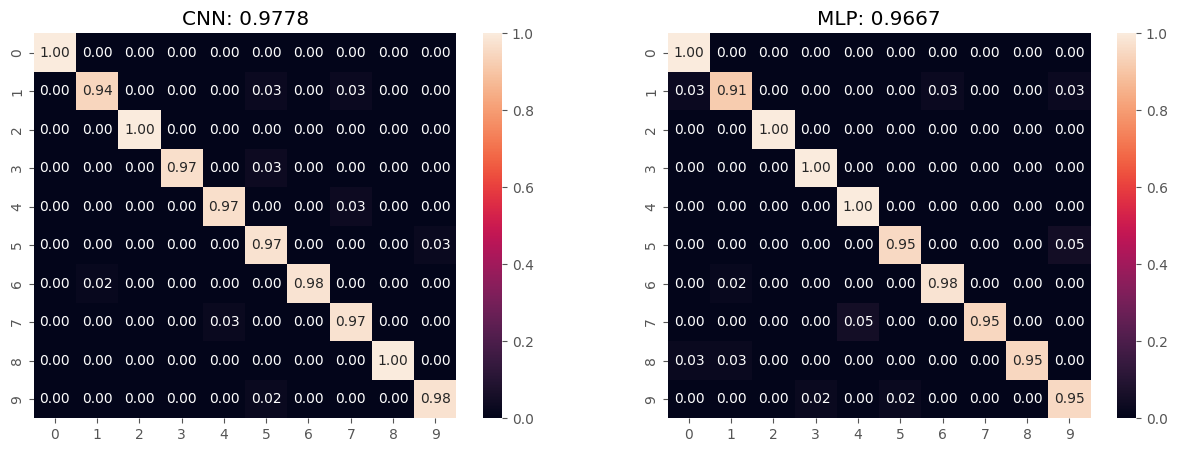

In [13]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer with increasing num filters
#    3. add more layers once flattened
cnn4 = Sequential(name='two_layer_few_filters')

num_filt_layers = [16, 32]
for num_filters in num_filt_layers:
    cnn4.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same'))
    cnn4.add( Activation('relu'))
    cnn4.add( MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn4.add( Flatten() )
cnn4.add( Dense(100) )
cnn4.add( Activation('relu') )
cnn4.add( Dense(NUM_CLASSES) )
cnn4.add( Activation('softmax') )

# Let's train the model 
cnn4.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

input_shape = [None, 8,8,1]
cnn4.build(input_shape)
print(cnn4.summary())

cnn4.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn4,mlp,X_test,y_test)

# Fashion MNIST
Okay, so we are honing in on the best performance for the digits data. But, we really need something a bit bigger to work on. Enter: Fashion MNIST. We have already used this dataset in the past, where we got about 84% accuracy with our custom MLP. Lets see how well Keras and tensorflow can perform!

Now let's load in a more diverse, harder to classify dataset: Fashion MNIST
https://www.kaggle.com/zalando-research/fashionmnist

**Labels**

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot 

In [14]:
# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
# from sklearn.preprocessing import RobustScaler
 
def load_mnist(path, kind='fashion_train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

X_train, y_train = load_mnist('data/', kind='fashion_train')
X_test, y_test = load_mnist('data/', kind='fashion_t10k')

X_train = X_train.reshape(X_train.shape[0],28,28,1)/255.0 - 0.5
X_test = X_test.reshape(X_test.shape[0],28,28,1)/255.0 - 0.5

print('X_train shape:', X_train.shape) 
print('X_test shape:', X_test.shape)

NUM_CLASSES = 10


# make one- hot encoded versions of the data
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


In [15]:
%%time

# make a keras MLP
mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=1, units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

input_shape = [None, 28,28,1]
mlp.build(input_shape)
print(mlp.summary())

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1)

/Users/eclarson/miniconda3/envs/mlenv3_11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,610 (338.32 KB)

 Trainable params: 86,610 (338.32 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7613 - loss: 0.6601
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8531 - loss: 0.4027
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8664 - loss: 0.3645
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8768 - loss: 0.3408
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8811 - loss: 0.3254
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8855 - loss: 0.3155
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8863 - loss: 0.3113
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8898 - loss: 0.3063
Epoch 9/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8903 - loss: 0.3083
Epoch 10/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8911 - loss: 0.3043
Epoch 11/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8930 - loss: 0.3060
Epoch 12/15
18

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


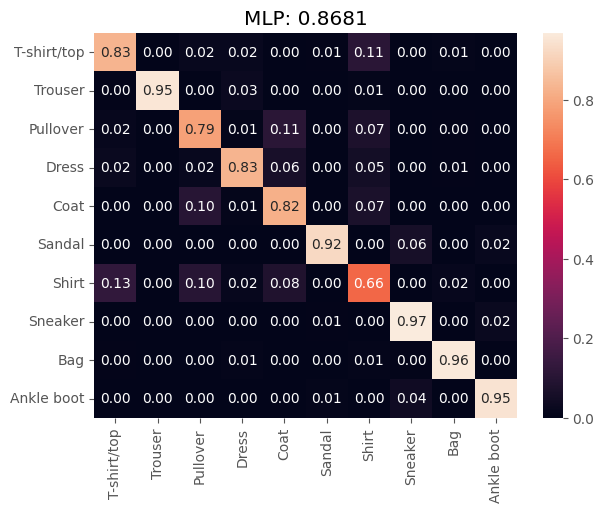

In [16]:
labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
compare_mlp_cnn(None,mlp,X_test,y_test,labels)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 24)     │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 28, 28, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 24)     │         5,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 14, 14, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1176)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │       117,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,258 (524.45 KB)

 Trainable params: 134,258 (524.45 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7146 - loss: 0.0376 - val_accuracy: 0.8635 - val_loss: 0.0196
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8772 - loss: 0.0176 - val_accuracy: 0.8848 - val_loss: 0.0167
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8976 - loss: 0.0150 - val_accuracy: 0.8919 - val_loss: 0.0157
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9093 - loss: 0.0134 - val_accuracy: 0.8972 - val_loss: 0.0151
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9166 - loss: 0.0122 - val_accuracy: 0.8975 - val_loss: 0.0148
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9249 - loss: 0.0113 - val_accuracy: 0.9050 - val_loss: 0.0140
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9311 - loss: 0.0105 - val_accuracy: 0.9026 - val_loss: 0.0143
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9365 - lo

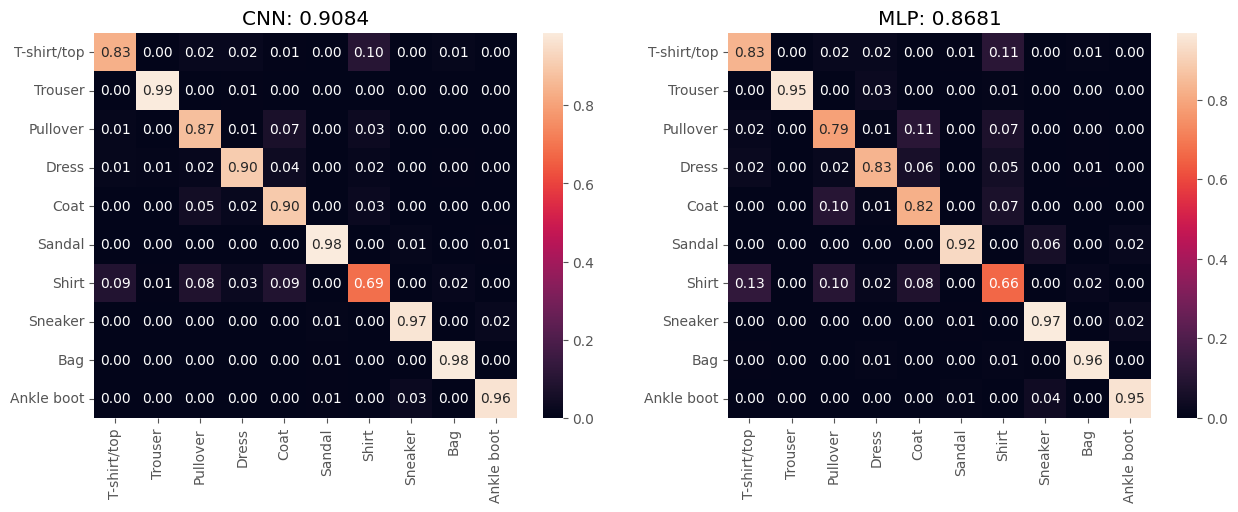

In [17]:
%%time

# changes: 
#    1. Baseline: 2 conv layers and two output layers
cnn1 = Sequential()

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same') )
    cnn1.add( Activation('relu'))
    cnn1.add( MaxPooling2D(pool_size=(2, 2), 
                           ) )
    

# add one layer on flattened output
cnn1.add( Flatten() )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

input_shape = [None, 28,28,1]
cnn1.build(input_shape)
print(cnn1.summary())

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn1.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1,
        validation_data=(X_test,y_test_ohe))

compare_mlp_cnn(cnn1,mlp,X_test,y_test,labels)

In [18]:
%%time
# Copy TensorFlow Architecture from 
#   Deep MNIST for experts
#   https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

# Manipulated to mirror parts of this network:
#   http://ankivil.com/mnist-database-and-simple-classification-networks/

cnn2 = Sequential()

num_filt_layers = [32, 64]
for num_filters in num_filt_layers:
    cnn2.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu',
                    ) ) # more compact syntax

    # max pooling
    cnn2.add( MaxPooling2D(pool_size=(2, 2) ) )
    

# add one layer on flattened output
cnn2.add( Dropout(0.25) ) # add some dropout for regularization after conv layers
cnn2.add( Flatten() )
cnn2.add( Dense(256, activation='relu') )
cnn2.add( Dropout(0.5) ) # add some dropout for regularization, again!
cnn2.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

input_shape = [None, 28,28,1]
cnn2.build(input_shape)
print(cnn2.summary())

history = cnn2.fit(X_train, y_train_ohe, 
            batch_size=128, epochs=30, 
            shuffle=True, verbose=1,
            validation_data=(X_test,y_test_ohe))



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 824,458 (3.15 MB)

 Trainable params: 824,458 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.7215 - loss: 0.7734 - val_accuracy: 0.8721 - val_loss: 0.3541
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8679 - loss: 0.3653 - val_accuracy: 0.8905 - val_loss: 0.3050
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8905 - loss: 0.3061 - val_accuracy: 0.9006 - val_loss: 0.2714
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9033 - loss: 0.2735 - val_accuracy: 0.9089 - val_loss: 0.2550
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9100 - loss: 0.2512 - val_accuracy: 0.9095 - val_loss: 0.2465
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9165 - loss: 0.2319 - val_accuracy: 0.9135 - val_loss: 0.2363
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9195 - loss: 0.2211 - val_accuracy: 0.9153 - val_loss: 0.2357
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9231 - loss: 0.20

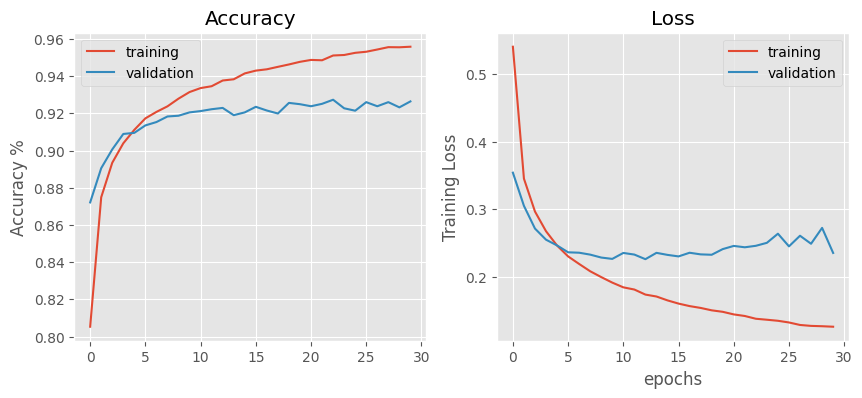

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


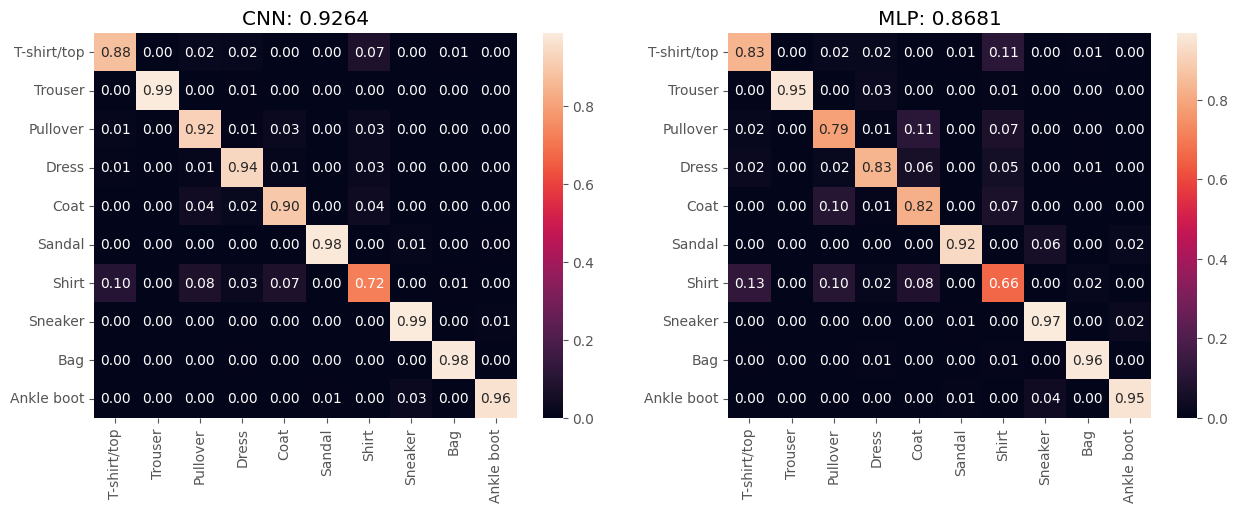

In [20]:
compare_mlp_cnn(cnn2,mlp,X_test,y_test,labels)

In [21]:
cnn2.evaluate(X_test,y_test_ohe,verbose=0)

[0.23536495864391327, 0.9264000058174133]

In [22]:
# want to save this model for later?
cnn2.save('large_data/mnist_cnn.h5')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


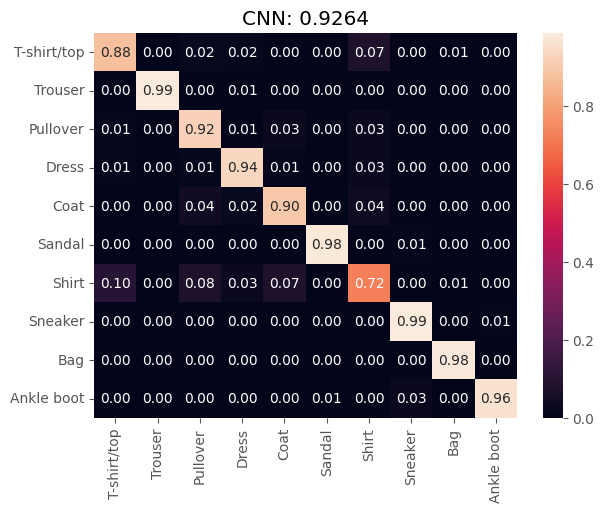

In [23]:
from tensorflow.keras.models import load_model

cnn_mnist = load_model('large_data/mnist_cnn.h5')
compare_mlp_cnn(cnn_mnist,None,X_test,y_test,labels)